*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containng both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*



---



For this challenge, you will complete the code below to classify images of dogs and cats. You will use Tensorflow 2.0 and Keras to create a convolutional neural network that correctly classifies images of cats and dogs at least 63% of the time. (Extra credit if you get it to 70% accuracy!)

Some of the code is given to you but some code you must fill in to complete this challenge. Read the instruction in each text cell so you will know what you have to do in each code cell.

The first code cell imports the required libraries. The second code cell downloads the data and sets key variables. The third cell is the first place you will write your own code.

The structure of the dataset files that are downloaded looks like this (You will notice that the test directory has no subdirectories and the images are not labeled):
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

You can tweak epochs and batch size if you like, but it is not required.

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128

--2021-11-25 13:40:52--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M   174MB/s    in 0.4s    

2021-11-25 13:40:52 (174 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Now it is your turn! Set each of the variables below correctly. (They should no longer equal `None`.)

Create image generators for each of the three image data sets (train, validation, test). Use `ImageDataGenerator` to read / decode the images and convert them into floating point tensors. Use the `rescale` argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the `*_data_gen` variables, use the `flow_from_directory` method. Pass in the batch size, directory, target size (`(IMG_HEIGHT, IMG_WIDTH)`), class mode, and anything else required. `test_data_gen` will be the trickiest one. For `test_data_gen`, make sure to pass in `shuffle=False` to the `flow_from_directory` method. This will make sure the final predictions stay is in the order that our test expects. For `test_data_gen` it will also be helpful to observe the directory structure.


After you run the code, the output should look like this:
```
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.
```

In [3]:
def create_generators():
    #Create generators for each part of our dataset.

    #First preprocess data. Maybe could apply transformations here.
    image_generator = ImageDataGenerator(
        rescale= 1 / 255.
    )
 
    return image_generator


def create_data_generators(batch_size, data_path, target_size, generator, shuffle=True):
    #Create flow directory.
    if shuffle:
      classes = None
    else:
      classes = ['.']
    data_generator = generator.flow_from_directory(
        data_path,
        class_mode='binary',
        target_size=target_size,
        color_mode='rgb',
        classes=classes,
        shuffle=shuffle,
        batch_size=batch_size
    )

    return data_generator

In [4]:
train_image_generator = create_generators()
validation_image_generator = create_generators()
test_image_generator = create_generators()

train_data_gen = create_data_generators(batch_size,train_dir,(IMG_HEIGHT,IMG_WIDTH),train_image_generator)
val_data_gen = create_data_generators(batch_size,validation_dir,(IMG_HEIGHT,IMG_WIDTH),validation_image_generator)
test_data_gen = create_data_generators(batch_size,test_dir,(IMG_HEIGHT,IMG_WIDTH),test_image_generator,shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


The `plotImages` function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the `train_data_gen` variable correctly, then running the cell below will plot five random training images.

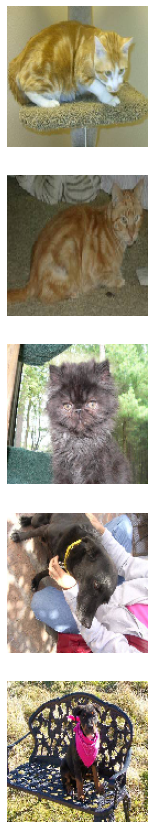

In [5]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Recreate the `train_image_generator` using `ImageDataGenerator`. 

Since there are a small number of training examples there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to `ImageDataGenerator`. Make sure to rescale the same as before.


In [6]:
train_image_generator = ImageDataGenerator(
        rescale= 1 / 255.,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.3,0.7),
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.15,
        zoom_range=0.2
      )


You don't have to do anything for the next cell. `train_data_gen` is created just like before but with the new `train_image_generator`. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


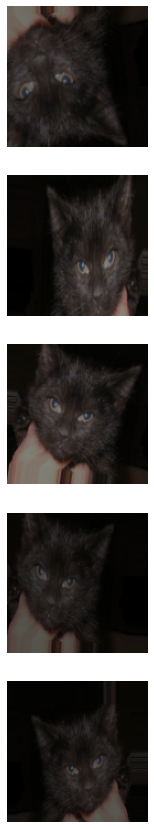

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In the cell below, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in `metrics=['accuracy']` to view training and validation accuracy for each training epoch.

In [8]:

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
  """Two convolution blocks"""
  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batchnorm:
      x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Encoding path
  conv_1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  maxpool_1 = MaxPooling2D((2, 2))(conv_1)
  p1 = Dropout(dropout)(maxpool_1)
  
  conv_2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  maxpool_2 = MaxPooling2D((2, 2))(conv_2)
  p2 = Dropout(dropout)(maxpool_2)
  
  conv_3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  maxpool_3 = MaxPooling2D((2, 2))(conv_3)
  p3 = Dropout(dropout)(maxpool_3)
  
  conv_4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  maxpool_4 = MaxPooling2D((2, 2))(conv_4)
  p4 = Dropout(dropout)(maxpool_4)
  
  conv_5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  outputs = Flatten()(conv_5)
  outputs = Dense(128, activation='relu')(outputs)
  outputs = Dense(2)(outputs) #Dense(1,activation='sigmoid')
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [9]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, GlobalAvgPool2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate

lr = 0.00001

input_img = Input((IMG_HEIGHT, IMG_WIDTH, 3), name='img')
model = get_unet(input_img=input_img)

#Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=True)

#loss function must be the same as loss generator.
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0     

Use the `fit` method on your `model` to train the network. Make sure to pass in arguments for `x`, `steps_per_epoch`, `epochs`, `validation_data`, and `validation_steps`.

In [10]:
#we can pass generator because we used flow_from_directory
epochs = 100
history =  model.fit(train_data_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=val_data_gen,
                  )

Epoch 1/100
16/16 [==============================] - 78s 5s/step - loss: 0.7872 - accuracy: 0.5120 - val_loss: 1.1113 - val_accuracy: 0.4990
Epoch 2/100
16/16 [==============================] - 77s 5s/step - loss: 0.7620 - accuracy: 0.5220 - val_loss: 0.8818 - val_accuracy: 0.4870
Epoch 3/100
16/16 [==============================] - 78s 5s/step - loss: 0.7577 - accuracy: 0.5310 - val_loss: 0.8795 - val_accuracy: 0.4960
Epoch 4/100
16/16 [==============================] - 78s 5s/step - loss: 0.7242 - accuracy: 0.5465 - val_loss: 0.8798 - val_accuracy: 0.4980
Epoch 5/100
16/16 [==============================] - 77s 5s/step - loss: 0.7276 - accuracy: 0.5635 - val_loss: 0.8559 - val_accuracy: 0.5000
Epoch 6/100
16/16 [==============================] - 77s 5s/step - loss: 0.7105 - accuracy: 0.5630 - val_loss: 0.8229 - val_accuracy: 0.5040
Epoch 7/100
16/16 [==============================] - 76s 5s/step - loss: 0.7018 - accuracy: 0.5655 - val_loss: 0.8233 - val_accuracy: 0.5060
Epoch 8/100
1

Run the next cell to visualize the accuracy and loss of the model.

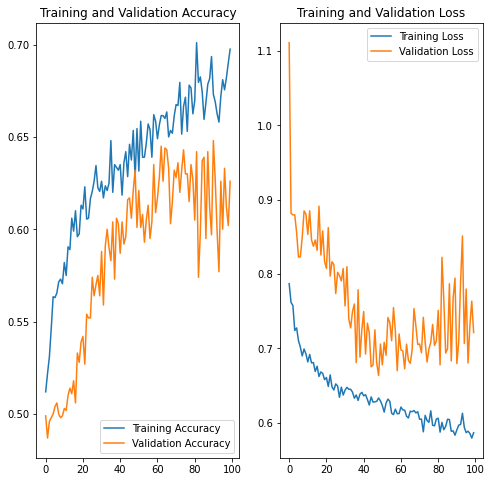

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this final cell, get the probability that each test image (from `test_data_gen`) is a dog or a cat. `probabilities` should be a list of integers. 

Call the `plotImages` function and pass in the test images and the probabilities corresponding to each test image.

After your run the cell, you should see all 50 test images with a label showing the percentage sure that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

In [12]:
import numpy as np
prediction = model.predict(test_data_gen)
probabilities = [0 if x[0]>x[1] else 1 for x in prediction]
print(probabilities)

[0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Run this final cell to see if you passed the challenge or if you need to keep trying.

In [13]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 0.68% of the images of cats and dogs.
You passed the challenge!
